In [151]:
import pandas as pd
import glob
import os

In [160]:
import pandas as pd
from pathlib import Path

def load_csvs_as_individual_dfs(folder_name, pattern="*.csv", dropna=True, drop_duplicates=True):
    """
    Loads each CSV file in the folder as its own cleaned DataFrame.
    
    Parameters:
    - folder_name: str or Path to the folder containing CSV files
    - pattern: glob pattern for file matching (default: "*.csv")
    - dropna: whether to drop rows with any null values (default: True)
    - drop_duplicates: whether to drop duplicate rows (default: True)

    Returns:
    - Dictionary {filename_without_ext: DataFrame}
    """
    folder = Path(folder_name)
    csv_files = folder.glob(pattern)
    dataframes = {}

    for file in csv_files:
        try:
            df = pd.read_csv(file)

            # Normalize columns
            df.columns = [col.strip().lower().replace('/', '_') for col in df.columns]

            # Parse 'date' column if present
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')

            # Drop rows with nulls if requested
            if dropna:
                df = df.dropna()

            # Drop duplicate rows if requested
            if drop_duplicates:
                df = df.drop_duplicates()

            # Store with filename (without extension) as key
            ticker = file.stem
            dataframes[ticker] = df

        except Exception as e:
            print(f"Failed to load {file.name}: {e}")

    print("All CSVs loaded and cleaned.")
    return dataframes


In [161]:
dfs = load_csvs_as_individual_dfs("penny_stocks_final_project")

print(dfs)
print(type(dfs))

All CSVs loaded and cleaned.
{'ADIL':           date close_last  volume    open    high     low
0   2025-05-16     $0.66    81909  $0.68   $0.68   $0.64 
1   2025-05-15     $0.66    70099  $0.68   $0.68   $0.63 
2   2025-05-14     $0.65   107375  $0.65   $0.67   $0.61 
3   2025-05-13     $0.63   372202  $0.64   $0.68   $0.60 
4   2025-05-12     $0.61   210683  $0.60   $0.63   $0.60 
..         ...        ...     ...     ...     ...     ...
244 2024-05-24     $1.25   119657  $1.27   $1.38   $1.20 
245 2024-05-23     $1.25   135382  $1.42   $1.42   $1.20 
246 2024-05-22     $1.42    50012  $1.40   $1.43   $1.36 
247 2024-05-21     $1.40    63916  $1.48   $1.49   $1.38 
248 2024-05-20     $1.50    43121  $1.55   $1.57   $1.48 

[249 rows x 6 columns], 'AEP':           date close_last   volume      open      high       low
0   2025-05-16   $103.04   2868876  $101.58   $103.09   $101.25 
1   2025-05-15   $101.61   5823998   $99.37   $101.70    $99.35 
2   2025-05-14    $98.59   5207425   $9

In [162]:
import pandas as pd

def process_stock_dataframes(stock_data_dict, output_csv='stock_features.csv'):
    all_features = []

    for stock_name, df in stock_data_dict.items():
        try:
            df = df.copy()

            # Convert date to datetime
            df['date'] = pd.to_datetime(df['date'])

            # Clean columns: remove $ and convert to numeric
            price_cols = ['close_last', 'open', 'high', 'low']
            for col in price_cols:
                df[col] = df[col].astype(str).str.replace('$', '', regex=False).astype(float)

            df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

            # Feature engineering
            df['daily_return'] = df['close_last'].pct_change()
            df['month'] = df['date'].dt.to_period('M')

            try:
                monthly = df.groupby('month').agg(
                    monthly_volume_mean=('volume', 'mean'),
                    monthly_price_change=(
                        'close_last',
                        lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] if len(x) > 1 else 0
                    )
                )
            except Exception as e:
                print(f"Monthly aggregation failed for {stock_name}: {e}")
                continue

            # Find all-time highest close and its date
            all_time_high = df['close_last'].max()
            date_when_highest = df.loc[df['close_last'].idxmax(), 'date']

            # Filter to only rows before the highest date (exclusive)
            df_before_high = df[df['date'] < date_when_highest]

            # Find the lowest close before the highest date
            if not df_before_high.empty:
                all_time_low = df_before_high['close_last'].min()
                date_when_lowest = df_before_high.loc[df_before_high['close_last'].idxmin(), 'date']
            else:
                # If no data before highest date, fallback to lowest close overall
                all_time_low = df['close_last'].min()
                date_when_lowest = df.loc[df['close_last'].idxmin(), 'date']

            features = {
                'stock_name': stock_name,
                'avg_close': df['close_last'].mean(),
                'volatility': df['daily_return'].std(),
                'daily_return_mean': df['daily_return'].mean(),
                'max_drawdown': (df['close_last'].cummax() - df['close_last']).max(),
                'avg_volume': df['volume'].mean(),
                'monthly_volume_std': monthly['monthly_volume_mean'].std(),
                'monthly_price_change_avg': monthly['monthly_price_change'].mean(),
                'monthly_price_change_std': monthly['monthly_price_change'].std(),
                'all_time_high': all_time_high,
                'all_time_low': all_time_low,
                'high_low_ratio': all_time_high / all_time_low if all_time_low > 0 else None,
                'date_when_highest': date_when_highest.date(),
                'date_when_lowest': date_when_lowest.date()
            }

            all_features.append(features)

        except Exception as e:
            print(f"Failed processing {stock_name}: {e}")

    if all_features:
        features_df = pd.DataFrame(all_features)
        try:
            features_df.to_csv(output_csv, mode='a', index=False, header=not pd.io.common.file_exists(output_csv))
        except Exception as e:
            print(f"Failed writing to CSV: {e}")


In [165]:
import pandas as pd

# Load existing features file
features_df = pd.read_csv('stock_features.csv')

# Define desired column order
columns_to_include = [
    'ticker', 'avg_close', 'volatility', 'daily_return_mean', 'max_drawdown',
    'avg_volume', 'monthly_volume_std', 'monthly_price_change_avg',
    'monthly_price_change_std', 'all_time_high', 'all_time_low',
    'high_low_ratio', 'all_time_high_date', 'all_time_low_date'
]

# Ensure all columns exist in the DataFrame
missing_cols = [col for col in columns_to_include if col not in features_df.columns]
if missing_cols:
    print(f"Warning: Missing columns {missing_cols} - they will be filled with NaN")
    for col in missing_cols:
        features_df[col] = pd.NA

# Select and reorder columns
features_df = features_df[columns_to_include]

# Create a new first row (empty or with default values)
new_row = pd.DataFrame([{col: pd.NA for col in columns_to_include}])

# Prepend the new row
features_df = pd.concat([new_row, features_df], ignore_index=True)

# Save to CSV
features_df.to_csv('stock_features.csv', index=False)


In [166]:
process_stock_dataframes(dfs, output_csv='stock_features.csv')


Failed processing MULN: could not convert string to float: '1,181.76 '


In [167]:
# Load CSV file
df = pd.read_csv('stock_features.csv')

# Drop rows with any missing values
df = df.dropna()

# Round float columns to 6 decimal places
float_cols = df.select_dtypes(include='float').columns
df[float_cols] = df[float_cols].round(6)

# Ensure date columns are in proper datetime format
df['all_time_high_date'] = pd.to_datetime(df['all_time_high_date'], errors='coerce')
df['all_time_low_date'] = pd.to_datetime(df['all_time_low_date'], errors='coerce')

# Remove rows where dates could not be parsed
df = df.dropna(subset=['all_time_high_date', 'all_time_low_date'])

# Save the cleaned data back to a CSV
df.to_csv('cleaned_file.csv', index=False)


In [168]:
import pandas as pd

def top_10_highest_percentage_difference(csv_file, top_n=41):
    df = pd.read_csv(csv_file)

    # Clean currency symbols or formatting if needed
    df['all_time_high'] = pd.to_numeric(df['all_time_high'].replace('[\$,]', '', regex=True), errors='coerce')
    df['all_time_low'] = pd.to_numeric(df['all_time_low'].replace('[\$,]', '', regex=True), errors='coerce')

    # Drop missing or invalid
    df = df.dropna(subset=['all_time_high', 'all_time_low'])
    df = df[df['all_time_low'] > 0]

    # Calculate percentage difference
    df['percentage_diff'] = (df['all_time_high'] - df['all_time_low']) / df['all_time_low'] * 100

    # Sort and get top N
    top_stocks = df.sort_values(by='percentage_diff', ascending=False).head(top_n)

    columns_to_show = [
        'ticker', 'avg_close', 'volatility', 'daily_return_mean', 'max_drawdown',
        'avg_volume', 'monthly_volume_std', 'monthly_price_change_avg', 'monthly_price_change_std',
        'all_time_high', 'all_time_low', 'high_low_ratio', 'percentage_diff'
    ]

    # Format floats to fixed decimal places to avoid scientific notation
    pd.options.display.float_format = '{:.6f}'.format

    return top_stocks[columns_to_show]

# Example usage
top_10 = top_10_highest_percentage_difference('cleaned_file.csv')
print(top_10)


   ticker  avg_close  volatility  daily_return_mean  max_drawdown  \
34   TVGN   1.030723    0.094242           0.003785      2.790000   
5    BBAI   2.676948    0.075473          -0.000388      8.590000   
2    APDN  21.207631    0.207647           0.033882    109.500000   
14   FOXO   2.417778    0.151715           0.018758      8.100000   
22   LODE   3.026546    0.092479           0.004087      7.460000   
23  MDXXF   0.130169    0.142934           0.012120      0.210000   
28   PRZO   0.911004    0.077402           0.002195      2.140000   
32    TMC   1.454819    0.059651          -0.001864      2.960000   
30   SIDU   2.400964    0.105471           0.008565      4.430000   
11   DTSS   2.557952    0.063856           0.005705      1.100000   
19   IAUX   0.831365    0.094415           0.006768      0.480000   
37   ZCAR  46.057676    0.248544           0.051111    183.400000   
20   IMRX   1.682771    0.065554           0.002308      2.180000   
0    ADIL   0.968313    0.048242  

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
C:\Users\josep\AppData\Local\Temp\ipykernel_13696\272125291.py:7: SyntaxWarning: invalid escape sequence '\$'
  df['all_time_high'] = pd.to_numeric(df['all_time_high'].replace('[\$,]', '', regex=True), errors='coerce')
C:\Users\josep\AppData\Local\Temp\ipykernel_13696\272125291.py:8: SyntaxWarning: invalid escape sequence '\$'
  df['all_time_low'] = pd.to_numeric(df['all_time_low'].replace('[\$,]', '', regex=True), errors='coerce')


In [170]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def compare_top_stocks(df, top_tickers):
    # Prepare features by dropping non-numeric columns
    features = df.drop(columns=['ticker', 'all_time_high_date', 'all_time_low_date']).fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Create a DataFrame for standardized features to keep ticker mapping
    features_scaled_df = pd.DataFrame(features_scaled, index=df['ticker'], columns=features.columns)
    
    # Separate the top stocks and others
    top_features = features_scaled_df.loc[top_tickers]
    other_features = features_scaled_df.drop(top_tickers)

    # Compute cosine similarity between each top ticker and all others
    similarity_matrix = cosine_similarity(top_features, other_features)

    # Wrap result in DataFrame for readability
    similarity_df = pd.DataFrame(similarity_matrix, index=top_tickers, columns=other_features.index)

    return similarity_df

# Load your data
df = pd.read_csv('stock_features.csv')

# Your top 5 tickers
top_tickers = ['TVGN', 'LODE', 'BBAI', 'APDN', 'FOXO']

# Calculate similarities
similarities = compare_top_stocks(df, top_tickers)

print(similarities)


ticker      ADIL       AEP     APEUF      ARBE      BDSX      BLDE       CAF  \
TVGN   -0.148825 -0.287722 -0.453621  0.032731 -0.531767 -0.303752 -0.402335   
LODE    0.013771 -0.332593 -0.206178  0.013517 -0.207579 -0.039659 -0.222171   
BBAI   -0.210764 -0.166350 -0.427470  0.260100 -0.549201 -0.315400 -0.340968   
APDN   -0.755507 -0.159031 -0.741640 -0.829371 -0.454101 -0.818526 -0.783240   
FOXO   -0.398815 -0.468196 -0.628751 -0.368344 -0.341832 -0.628685 -0.771367   

ticker      CERO      CRON      DTSS  ...      PLUG      PRZO      RANI  \
TVGN   -0.291942 -0.447570  0.296978  ...  0.061671  0.807800 -0.628514   
LODE   -0.210541 -0.246320  0.666290  ... -0.426924  0.881111 -0.326124   
BBAI   -0.399201 -0.330477 -0.289306  ...  0.766024  0.364581 -0.649052   
APDN    0.765212 -0.822821 -0.305788  ... -0.197527 -0.143790 -0.202670   
FOXO    0.292055 -0.722557  0.104741  ... -0.077259  0.437666 -0.236057   

ticker     SIDU      TLRY       TMC      TNXP      WISE      XTKG   

In [171]:
def print_top_similar_stocks(similarity_df, top_n=10):
    for ticker in similarity_df.index:
        print(f"\nTop {top_n} stocks most similar to {ticker}:")
        # Sort similarity scores descending and take top_n
        top_similar = similarity_df.loc[ticker].sort_values(ascending=False).head(top_n)
        print(top_similar)

# Using the previous code to get `similarities`
print_top_similar_stocks(similarities, top_n=10)



Top 10 stocks most similar to TVGN:
ticker
PRZO     0.807800
SIDU     0.763029
TMC      0.594709
IAUX     0.473791
MDXXF    0.463254
DTSS     0.296978
IMRX     0.203878
PLUG     0.061671
ARBE     0.032731
NGD     -0.024350
Name: TVGN, dtype: float64

Top 10 stocks most similar to LODE:
ticker
PRZO    0.881111
SIDU    0.722905
MDXXF   0.701482
DTSS    0.666290
TMC     0.634237
IAUX    0.482008
IMRX    0.292439
GTEC    0.124561
HIMX    0.072874
OPTX    0.031090
Name: LODE, dtype: float64

Top 10 stocks most similar to BBAI:
ticker
PLUG    0.766024
TLRY    0.558217
NGD     0.456759
SIDU    0.416581
PRZO    0.364581
TMC     0.342631
IAUX    0.338112
ARBE    0.260100
IMRX    0.158422
LAC    -0.035936
Name: BBAI, dtype: float64

Top 10 stocks most similar to APDN:
ticker
ZCAR     0.920622
CERO     0.765212
TNXP     0.502460
MDXXF    0.463273
XTKG     0.347098
SIDU     0.103551
OPTX     0.038059
PRZO    -0.143790
AEP     -0.159031
PLUG    -0.197527
Name: APDN, dtype: float64

Top 10 stocks m

In [172]:
# Ensure the date columns are datetime
df = pd.read_csv('cleaned_file.csv')

df['all_time_high_date'] = pd.to_datetime(df['all_time_high_date'], errors='coerce')
df['all_time_low_date'] = pd.to_datetime(df['all_time_low_date'], errors='coerce')

# Drop rows with missing dates
df = df.dropna(subset=['all_time_high_date', 'all_time_low_date'])

# Calculate absolute difference in days
df['date_diff_days'] = (df['all_time_high_date'] - df['all_time_low_date']).abs().dt.days

# Calculate average difference
average_difference = df['date_diff_days'].mean()

print(f"Average length difference between all-time high and low dates: {average_difference:.2f} days")
mean_diff = df['date_diff_days'].mean()
median_diff = df['date_diff_days'].median()

print(f"Mean difference: {mean_diff:.2f} days")
print(f"Median difference: {median_diff:.2f} days")


Average length difference between all-time high and low dates: 93.97 days
Mean difference: 93.97 days
Median difference: 56.50 days


In [173]:
import pandas as pd

def extract_pre_high_data(dfs, tickers, days=60):
    """
    Extracts `days` of data before the highest close for each specified stock ticker.
    
    Parameters:
    - dfs: dict of stock dataframes
    - tickers: list of tickers to extract
    - days: number of days to look back from highest close
    
    Returns:
    - dfs_node_selector: dict of filtered dataframes
    """
    dfs_node_selector = {}

    for ticker in tickers:
        if ticker not in dfs:
            print(f"{ticker} not found in data.")
            continue

        df = dfs[ticker].copy()
        
        # Convert date column
        df['date'] = pd.to_datetime(df['date'])

        # Clean and convert closing prices
        df['close_last'] = df['close_last'].replace('[\$,]', '', regex=True).astype(float)

        # Sort by date just in case
        df = df.sort_values(by='date').reset_index(drop=True)

        # Find the index and date of max close
        max_idx = df['close_last'].idxmax()
        max_date = df.loc[max_idx, 'date']

        # Filter rows before the max close date
        pre_high_df = df[df['date'] < max_date]

        # If fewer than `days` rows exist, take all available, else take last `days`
        if len(pre_high_df) < days:
            result_df = pre_high_df
        else:
            result_df = pre_high_df.tail(days)

        dfs_node_selector[ticker] = result_df

    return dfs_node_selector


<>:28: SyntaxWarning: invalid escape sequence '\$'
<>:28: SyntaxWarning: invalid escape sequence '\$'
C:\Users\josep\AppData\Local\Temp\ipykernel_13696\4228945482.py:28: SyntaxWarning: invalid escape sequence '\$'
  df['close_last'] = df['close_last'].replace('[\$,]', '', regex=True).astype(float)


In [191]:
import pandas as pd

def add_target_to_dfs(dfs, lookback_days=50):
    dfs_with_target = {}
    
    for ticker, df in dfs.items():
        df_copy = df.copy()
        
        # Clean close_last: remove '$' and convert to float
        df_copy['close_last'] = df_copy['close_last'].replace('[\$,]', '', regex=True).astype(float)
        
        # Convert date to datetime and sort ascending by date
        df_copy['date'] = pd.to_datetime(df_copy['date'])
        df_copy = df_copy.sort_values('date').reset_index(drop=True)
        
        # Find index of max close_last
        max_idx = df_copy['close_last'].idxmax()
        
        # Initialize target column with 0s
        df_copy['target'] = 0
        
        # Calculate start index for target=1 (max_idx - lookback_days + 1)
        start_idx = max(0, max_idx - lookback_days + 1)
        
        # Set target=1 for the lookback window including max day
        df_copy.loc[start_idx:max_idx, 'target'] = 1
        
        # Store back in new dictionary
        dfs_with_target[ticker] = df_copy
        
    return dfs_with_target


<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
C:\Users\josep\AppData\Local\Temp\ipykernel_13696\225988509.py:10: SyntaxWarning: invalid escape sequence '\$'
  df_copy['close_last'] = df_copy['close_last'].replace('[\$,]', '', regex=True).astype(float)


In [200]:
dfs_with_targets = add_target_to_dfs(dfs, lookback_days=50)

for ticker, df in dfs_with_targets.items():
    print(f"\nTicker: {ticker}")
    print(df)



Ticker: ADIL
          date  close_last  volume    open    high     low  target
0   2024-05-20    1.500000   43121  $1.55   $1.57   $1.48        1
1   2024-05-21    1.400000   63916  $1.48   $1.49   $1.38        0
2   2024-05-22    1.420000   50012  $1.40   $1.43   $1.36        0
3   2024-05-23    1.250000  135382  $1.42   $1.42   $1.20        0
4   2024-05-24    1.250000  119657  $1.27   $1.38   $1.20        0
..         ...         ...     ...     ...     ...     ...     ...
244 2025-05-12    0.610000  210683  $0.60   $0.63   $0.60        0
245 2025-05-13    0.630000  372202  $0.64   $0.68   $0.60        0
246 2025-05-14    0.650000  107375  $0.65   $0.67   $0.61        0
247 2025-05-15    0.660000   70099  $0.68   $0.68   $0.63        0
248 2025-05-16    0.660000   81909  $0.68   $0.68   $0.64        0

[249 rows x 7 columns]

Ticker: AEP
          date  close_last   volume      open      high       low  target
0   2024-05-20   92.590000  1725367   $92.84    $92.84    $92.14       

In [205]:
# Assuming dfs_with_targets is your dict with target column added

filtered_dfs = {}

for ticker, df in dfs_with_targets.items():
    target_count = df['target'].sum()
    if target_count >= 20:
        # Drop the target column here
        df_no_target = df.drop(columns=['target'])
        filtered_dfs[ticker] = df_no_target
    else:
        print(f"Removed {ticker} due to insufficient target days ({target_count})")

# filtered_dfs now contains only stocks with at least 20 target days and no 'target' column


Removed ADIL due to insufficient target days (1)
Removed CERO due to insufficient target days (1)
Removed CRON due to insufficient target days (3)
Removed DTSS due to insufficient target days (1)
Removed GRUSF due to insufficient target days (3)
Removed IAUX due to insufficient target days (1)
Removed MULN due to insufficient target days (1)
Removed NAT due to insufficient target days (2)
Removed PLUG due to insufficient target days (10)
Removed RANI due to insufficient target days (9)
Removed TNXP due to insufficient target days (1)
Removed XTKG due to insufficient target days (14)
Removed ZCAR due to insufficient target days (11)


In [210]:
for ticker, df in filtered_dfs.items():
    print(f"\nTicker: {ticker}")
    print(df)



Ticker: AEP
          date  close_last   volume      open      high       low  target
0   2024-05-20   92.590000  1725367   $92.84    $92.84    $92.14        0
1   2024-05-21   92.620000  2247626   $92.59    $93.44    $92.37        0
2   2024-05-22   91.480000  2361649   $92.07    $92.45    $91.34        0
3   2024-05-23   89.280000  2182791   $91.13    $91.13    $89.21        0
4   2024-05-24   88.970000  3123525   $89.48    $89.80    $88.84        0
..         ...         ...      ...       ...       ...       ...     ...
244 2025-05-12  100.990000  4449894  $103.14   $103.61   $100.57        0
245 2025-05-13   99.560000  4607400  $100.99   $101.28    $99.38        0
246 2025-05-14   98.590000  5207425   $99.27    $99.29    $97.46        0
247 2025-05-15  101.610000  5823998   $99.37   $101.70    $99.35        0
248 2025-05-16  103.040000  2868876  $101.58   $103.09   $101.25        0

[249 rows x 7 columns]

Ticker: APDN
          date  close_last   volume      open      high      

In [213]:

def clean_dfs(dfs):
    for ticker, df in dfs.items():
        df = df.copy()

        # Convert date column to datetime
        df['date'] = pd.to_datetime(df['date'])

        # Remove $ sign and convert price columns to float
        for col in ['close_last', 'open', 'high', 'low']:
            if col in df.columns:
                df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

        # Convert volume to numeric (in case it's string)
        if 'volume' in df.columns:
            df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

        dfs[ticker] = df

    return dfs


<>:11: SyntaxWarning: invalid escape sequence '\$'
<>:11: SyntaxWarning: invalid escape sequence '\$'
C:\Users\josep\AppData\Local\Temp\ipykernel_13696\2414180811.py:11: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)


In [223]:
please_work=clean_dfs(filtered_dfs)


In [224]:
print(please_work)

{'AEP':           date  close_last   volume       open       high        low  target
0   2024-05-20   92.590000  1725367  92.840000  92.840000  92.140000       0
1   2024-05-21   92.620000  2247626  92.590000  93.440000  92.370000       0
2   2024-05-22   91.480000  2361649  92.070000  92.450000  91.340000       0
3   2024-05-23   89.280000  2182791  91.130000  91.130000  89.210000       0
4   2024-05-24   88.970000  3123525  89.480000  89.800000  88.840000       0
..         ...         ...      ...        ...        ...        ...     ...
244 2025-05-12  100.990000  4449894 103.140000 103.610000 100.570000       0
245 2025-05-13   99.560000  4607400 100.990000 101.280000  99.380000       0
246 2025-05-14   98.590000  5207425  99.270000  99.290000  97.460000       0
247 2025-05-15  101.610000  5823998  99.370000 101.700000  99.350000       0
248 2025-05-16  103.040000  2868876 101.580000 103.090000 101.250000       0

[249 rows x 7 columns], 'APDN':           date  close_last   volume

In [225]:
def add_features(df):
    df = please_work.copy()
    for col in ['close_last', 'open', 'high', 'low']:
        df[col] = df[col].astype(float)

    df['daily_return'] = df['close_last'].pct_change()
    df['ma_5'] = df['close_last'].rolling(window=5).mean()
    df['ma_10'] = df['close_last'].rolling(window=10).mean()
    df['volatility_5'] = df['daily_return'].rolling(window=5).std()
    df['volatility_10'] = df['daily_return'].rolling(window=10).std()
    df['vol_avg_5'] = df['volume'].rolling(window=5).mean()
    df['vol_avg_10'] = df['volume'].rolling(window=10).mean()
    df['vol_change'] = df['volume'].pct_change()
    df['price_range'] = df['high'] - df['low']
    df['close_open_ratio'] = df['close_last'] / df['open']
    df = df.fillna(0)
    return df

# Apply feature addition to all filtered dataframes:
filtered_dfs_with_features = {}

for ticker, df in filtered_dfs.items():
    filtered_dfs_with_features[ticker] = add_features(df)

print(filtered_dfs_with_features['AEP'].head())
print(df)


KeyError: 'close_last'

In [226]:
import pandas as pd

# List to collect DataFrames
df_list = []

# Loop through the dictionary
for ticker, df in please_work.items():
    df_copy = df.copy()
    df_copy['ticker'] = ticker  # Add ticker column
    df_list.append(df_copy)

# Combine all into one DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Save to CSV
combined_df.to_csv('tree_stock.csv', index=False)


In [227]:
import pandas as pd

def add_features(df):
    df = df.copy()
    for col in ['close_last', 'open', 'high', 'low']:
        df[col] = df[col].astype(float)

    df['daily_return'] = df['close_last'].pct_change()
    df['ma_5'] = df['close_last'].rolling(window=5).mean()
    df['ma_10'] = df['close_last'].rolling(window=10).mean()
    df['volatility_5'] = df['daily_return'].rolling(window=5).std()
    df['volatility_10'] = df['daily_return'].rolling(window=10).std()
    df['vol_avg_5'] = df['volume'].rolling(window=5).mean()
    df['vol_avg_10'] = df['volume'].rolling(window=10).mean()
    df['vol_change'] = df['volume'].pct_change()
    df['price_range'] = df['high'] - df['low']
    df['close_open_ratio'] = df['close_last'] / df['open']
    
    df = df.fillna(0)
    return df

# Load input CSV
input_df = pd.read_csv('tree_stock.csv')  # Change this to your actual file name

# Ensure proper sorting
input_df['date'] = pd.to_datetime(input_df['date'])
input_df = input_df.sort_values(['ticker', 'date'])

# Apply feature engineering to each stock (grouped by ticker)
processed_frames = []

for ticker, group in input_df.groupby('ticker'):
    group_with_features = add_features(group)
    processed_frames.append(group_with_features)

# Combine all stocks back into one DataFrame
prepped_df = pd.concat(processed_frames).reset_index(drop=True)

# Save to new CSV
prepped_df.to_csv('prepped_tree_stocks.csv', index=False)

print("Saved prepped data to prepped_tree_stocks.csv")


Saved prepped data to prepped_tree_stocks.csv


Confusion Matrix:
[[616 404]
 [191  59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.60      0.67      1020
           1       0.13      0.24      0.17       250

    accuracy                           0.53      1270
   macro avg       0.45      0.42      0.42      1270
weighted avg       0.64      0.53      0.57      1270



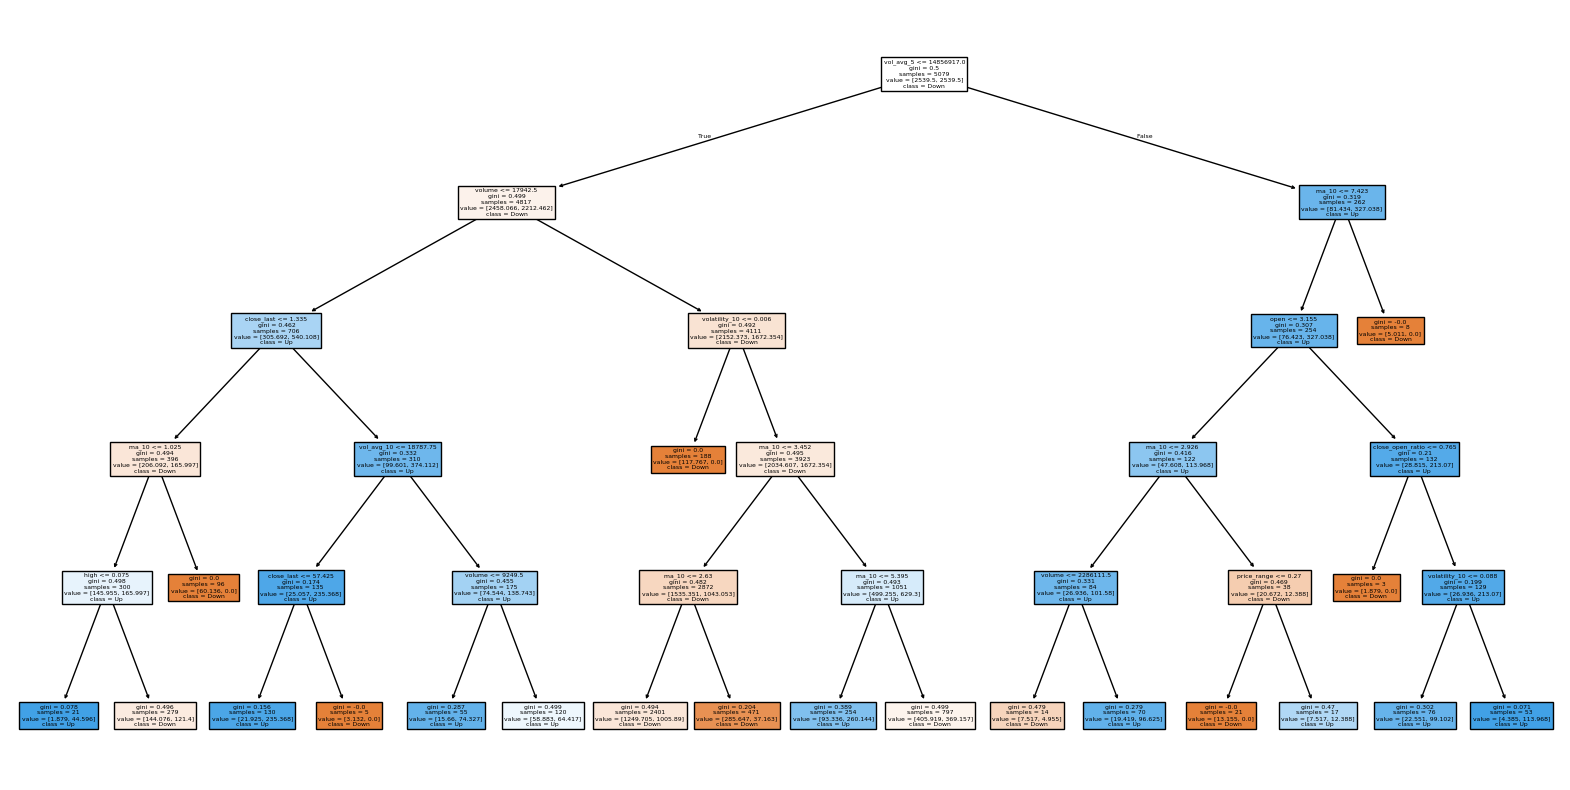

In [229]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Load the preprocessed data
df = pd.read_csv("prepped_tree_stocks.csv")

# Drop non-numeric / irrelevant columns
df = df.drop(columns=['date', 'ticker'])

# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Visualize the tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X.columns, class_names=['Down', 'Up'], filled=True)
plt.show()
